In [3]:

!pip install ultralytics opencv-python -q
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.1 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:

import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split

# Paths to CSV files and image directories
greencsv_path = '/content/drive/MyDrive/Tomato_dataset/xml_files/phone1-green_fruits.csv'
ripecsv_path = '/content/drive/MyDrive/Tomato_dataset/phone1_ripe/phone1_ripe.csv'
green_image_dir = '/content/drive/MyDrive/Tomato_dataset/Phone1_green_Fruits'
ripe_image_dir = '/content/drive/MyDrive/Tomato_dataset/phone1_ripe'

# Read both CSVs
green_data = pd.read_csv(greencsv_path)
ripe_data = pd.read_csv(ripecsv_path)

# Standardize column names
green_data = green_data.rename(columns={
    'filename': 'image_name',
    'class': 'label_name',
    'xmin': 'bbox_x',
    'ymin': 'bbox_y',
    'xmax': 'bbox_xmax',
    'ymax': 'bbox_ymax'
})
# Convert green_data bounding boxes to width/height format
green_data['bbox_width'] = green_data['bbox_xmax'] - green_data['bbox_x']
green_data['bbox_height'] = green_data['bbox_ymax'] - green_data['bbox_y']

# Add image_width and image_height for green_data (assuming 3072x4080 based on ripe_data)
green_data['image_width'] = 3072
green_data['image_height'] = 4080

# Select relevant columns for consistency
green_data = green_data[['image_name', 'label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height']]
ripe_data = ripe_data[['image_name', 'label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height']]

# Add image directory column
green_data['image_dir'] = green_image_dir
ripe_data['image_dir'] = ripe_image_dir

# Combine the DataFrames
data = pd.concat([green_data, ripe_data], ignore_index=True)

# Check for missing or invalid label_name values
print("Missing label_name values:", data['label_name'].isna().sum())
print("Unique label_name values before cleaning:", data['label_name'].unique())

# Drop rows with missing or non-string label_name values
data = data.dropna(subset=['label_name'])
data = data[data['label_name'].apply(lambda x: isinstance(x, str))]

# Fix label mismatches
label_mapping = {
    'G.latebright': 'G.lateblight',
    'R.latebright': 'R.lateblight',
    'R.ber': 'R.BER'
}
data['label_name'] = data['label_name'].replace(label_mapping)

# Extract prefix (G or R) for binary classification
data['binary_class'] = data['label_name'].apply(lambda x: x.split('.')[0])

# Verify binary classes
print("Unique binary classes:", data['binary_class'].unique())
if not all(label in ['G', 'R'] for label in data['binary_class'].unique()):
    print("Warning: Unexpected binary classes found:", data['binary_class'].unique())

# Get unique filenames and split into train/val
unique_filenames = data['image_name'].unique()
train_filenames, val_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=42)

# Create dataset directories
dataset_dir = '/content/dataset'
images_train_dir = os.path.join(dataset_dir, 'images', 'train')
images_val_dir = os.path.join(dataset_dir, 'images', 'val')
labels_train_dir = os.path.join(dataset_dir, 'labels', 'train')
labels_val_dir = os.path.join(dataset_dir, 'labels', 'val')

os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(labels_train_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)

# Class mapping: G -> 0 (green), R -> 1 (ripe)
class_map = {'G': 0, 'R': 1}

# Function to create YOLO label file for an image
def create_yolo_label(filename, split_dir, is_train=True):
    annotations = data[data['image_name'] == filename]
    if annotations.empty:
        return

    # Get image path and size
    image_dir = annotations['image_dir'].iloc[0]
    image_path = os.path.join(image_dir, filename)
    width = annotations['image_width'].iloc[0]
    height = annotations['image_height'].iloc[0]

    # Copy image to dataset folder
    dest_image_dir = images_train_dir if is_train else images_val_dir
    shutil.copy(image_path, os.path.join(dest_image_dir, filename))

    # Create label file
    label_path = os.path.join(labels_train_dir if is_train else labels_val_dir, filename.replace('.jpg', '.txt'))
    with open(label_path, 'w') as f:
        for _, ann in annotations.iterrows():
            cls = class_map[ann['binary_class']]
            x_center = (ann['bbox_x'] + ann['bbox_width'] / 2) / width
            y_center = (ann['bbox_y'] + ann['bbox_height'] / 2) / height
            w = ann['bbox_width'] / width
            h = ann['bbox_height'] / height
            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Create labels for train and val
for filename in train_filenames:
    create_yolo_label(filename, 'train', is_train=True)
for filename in val_filenames:
    create_yolo_label(filename, 'val', is_train=False)

print(f"Dataset prepared with {len(train_filenames)} train images and {len(val_filenames)} val images.")

Missing label_name values: 0
Unique label_name values before cleaning: ['G.spots' 'G.healthy' 'R.healthy' 'G.latebright' 'R.ber' 'G.ber'
 'R.latebright' 'G.pests' 'R.spots' 'R.pests']
Unique binary classes: ['G' 'R']
Dataset prepared with 246 train images and 62 val images.


In [5]:
# Cell 3: Create data.yaml for YOLO
import os

yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 2
names: ['green', 'ripe']
"""

yaml_path = '/content/data.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

# Verify data.yaml creation
if os.path.exists(yaml_path):
    print(f"data.yaml created at {yaml_path}")
    with open(yaml_path, 'r') as f:
        print("data.yaml content:\n", f.read())
else:
    print(f"Failed to create data.yaml at {yaml_path}")

data.yaml created at /content/data.yaml
data.yaml content:
 
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 2
names: ['green', 'ripe']



In [10]:
from ultralytics import YOLO
import os

# Verify data.yaml exists
yaml_path = '/content/data.yaml'
if not os.path.exists(yaml_path):
    print(f"Error: {yaml_path} does not exist")
    raise FileNotFoundError(f"{yaml_path} does not exist")

# Load a pretrained YOLOv8 nano model (lightweight for TFLite/Raspberry Pi)
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(data=yaml_path, epochs=50, imgsz=224, batch=32, augment=True)

print("Training completed.")

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

In [12]:
# Cell 5: Export Model to TFLite
import os

# Export the model to TFLite format
model.export(format='tflite')

# Find the exported TFLite model (path may vary based on YOLO version)
tflite_path = '/content/runs/detect/train/weights/best_saved_model/best_float32.tflite'
if not os.path.exists(tflite_path):
    print(f"Warning: Expected TFLite path {tflite_path} not found. Checking alternative paths...")
    import glob
    tflite_files = glob.glob('/content/runs/detect/train*/weights/best_saved_model/*.tflite')
    if tflite_files:
        tflite_path = tflite_files[0]
        print(f"Found TFLite model at {tflite_path}")
    else:
        print("Error: No TFLite model found in /content/runs/detect/train*/weights/best_saved_model/")
        raise FileNotFoundError("TFLite model not found")

print(f"TFLite model exported to {tflite_path}")

# Copy to Google Drive
!cp {tflite_path} /content/drive/MyDrive/Tomato_dataset/model_object_detection.tflite
print("TFLite model saved to Google Drive.")

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 6, 1029) (5.9 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1rc1 opset 22...
ONNX: slimming with onnxslim 0.1.70...
ONNX: export success ✅ 0.9s, saved as '/content/runs/detect/train2/weights/best.onnx' (11.6 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.2...
Saved artifact at '/content/runs/detect/train2/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 6, 1029), dtype=tf.float32, name=None)
Captures:
  137349377109520: TensorSpec(sh


image 1/1 /content/drive/MyDrive/Tomato_dataset/tomato_fruits/IMG_20250905_152208.jpg: 224x192 1 green, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 192)
Output image saved to /content/output.jpg


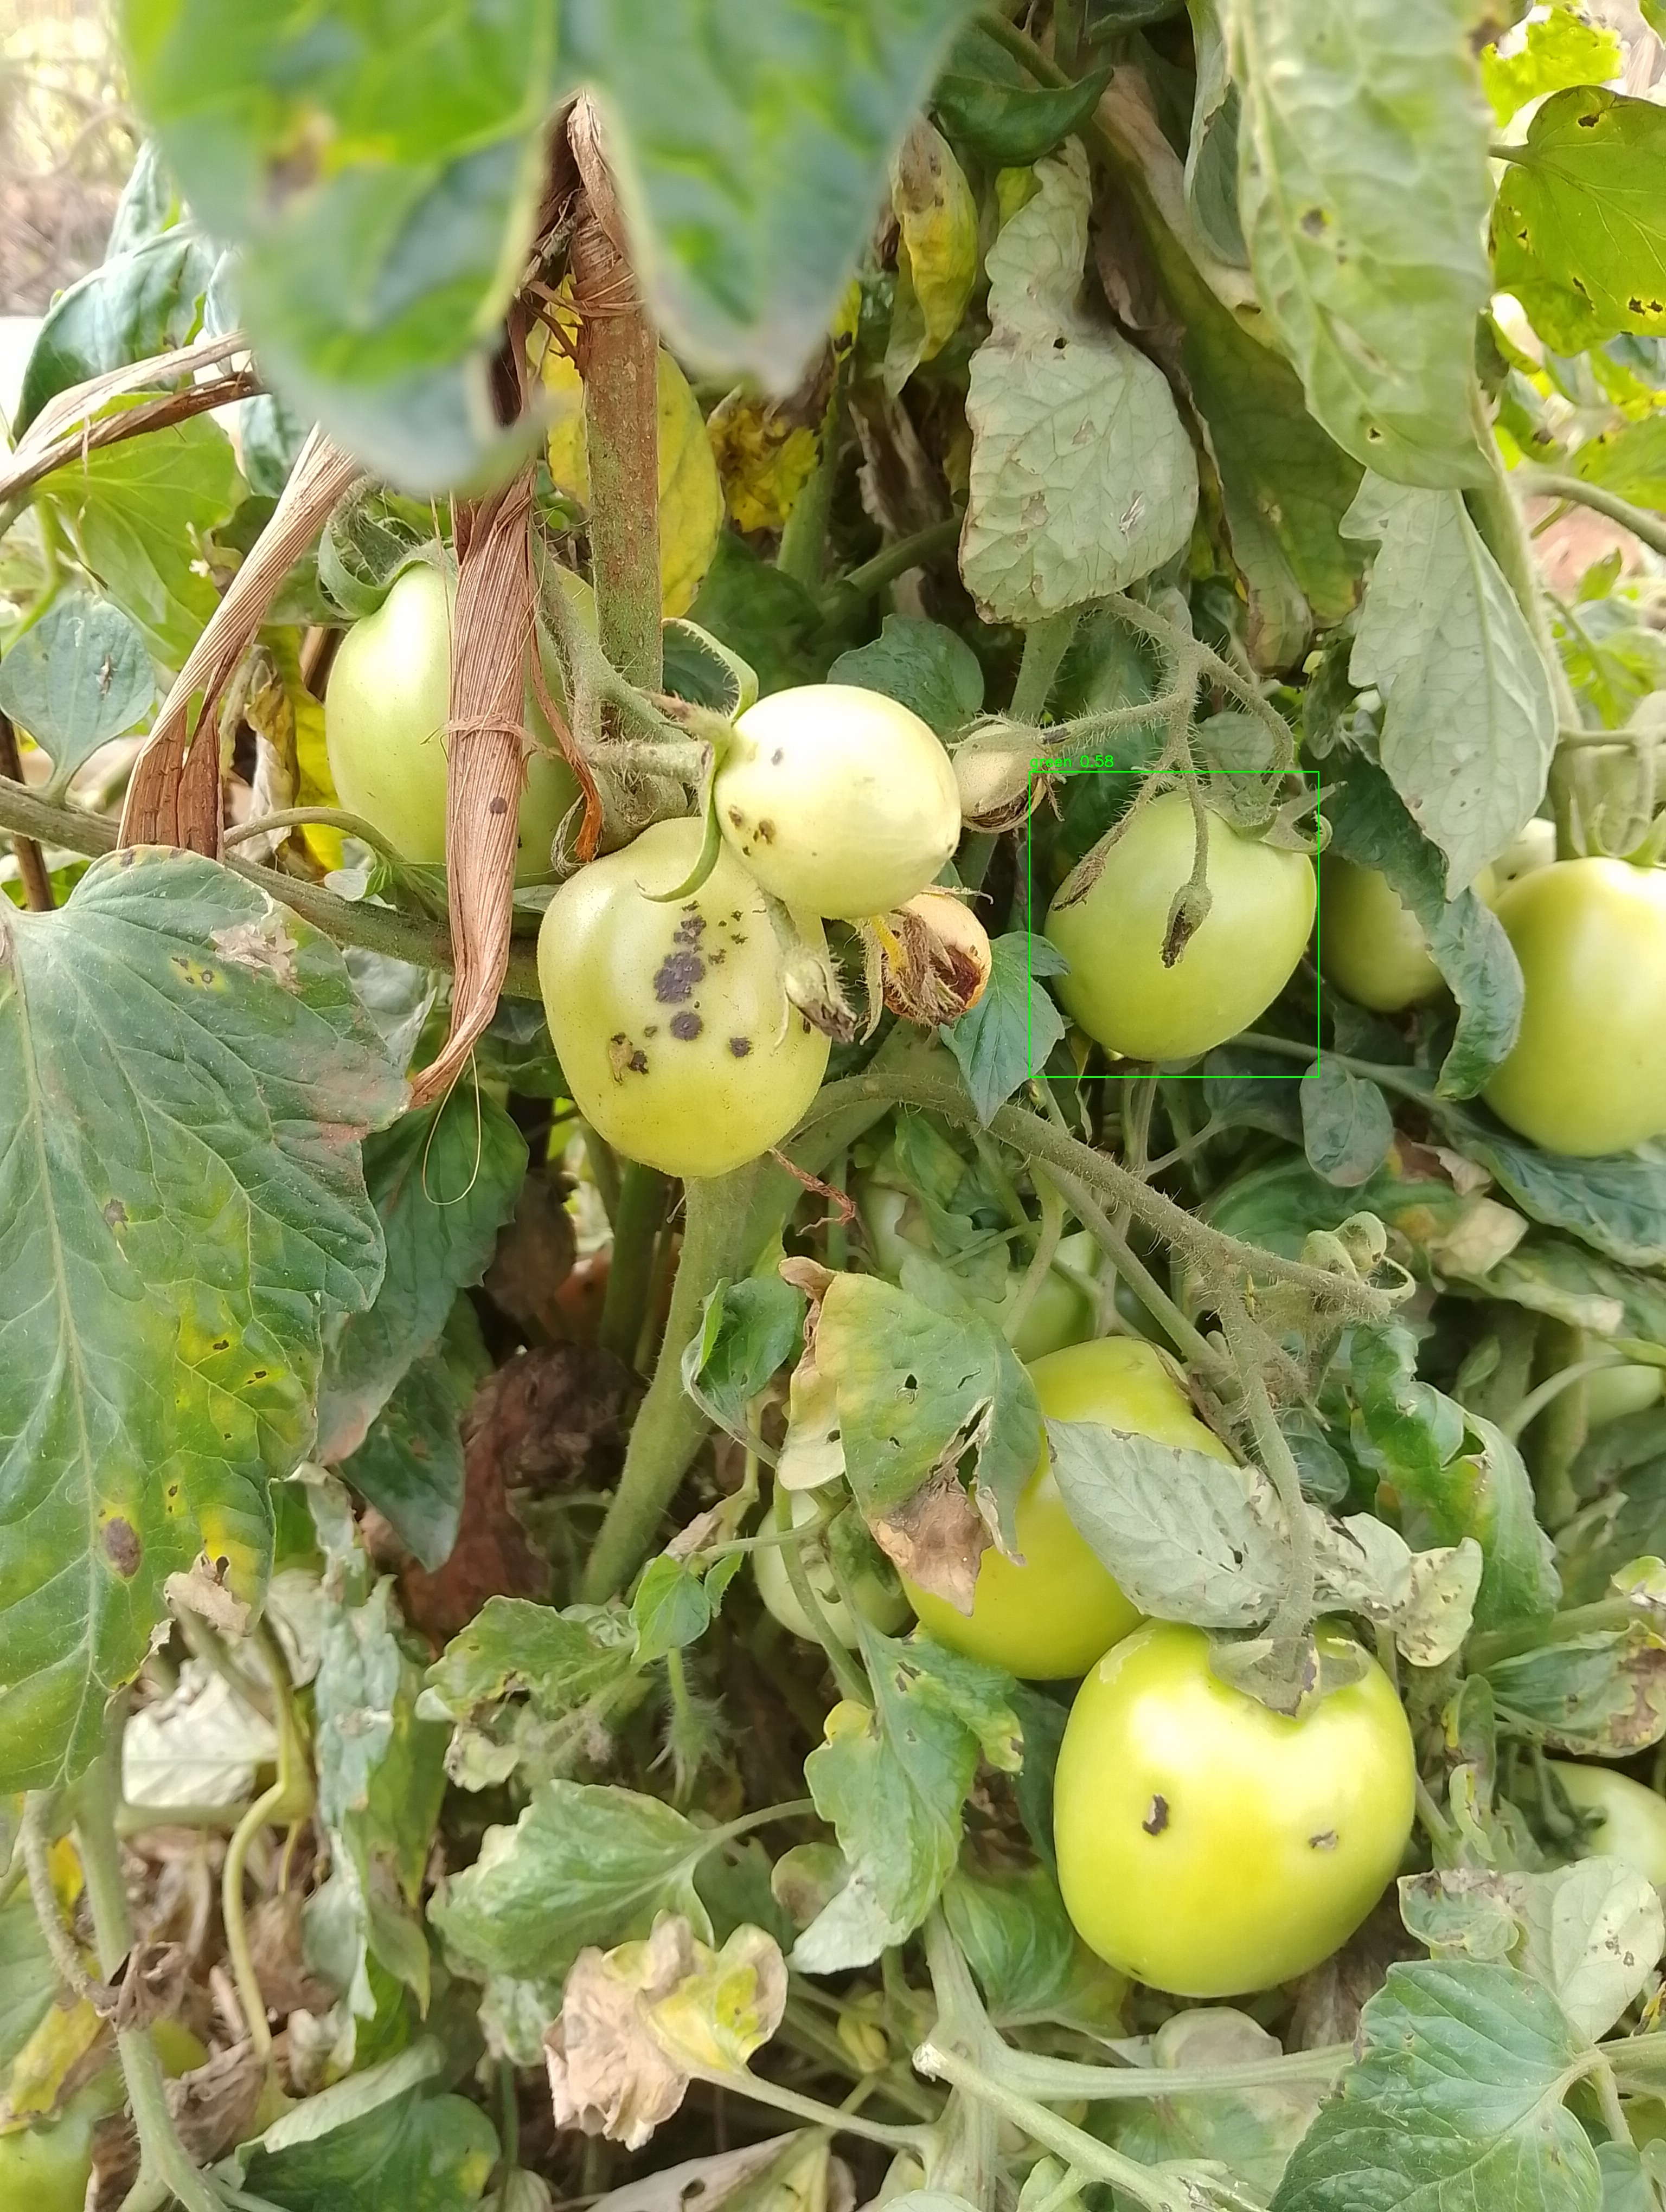

In [14]:
# Cell 6: Test the Model on an Image and Draw Bounding Boxes
import cv2
from ultralytics import YOLO
from IPython.display import Image as IPImage, display

# Load the trained model (use the best.pt from training)
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Adjust path if needed

def test_and_draw_boxes(image_path, output_path='/content/output.jpg'):
    if not os.path.exists(image_path):
        print(f"Error: Test image {image_path} does not exist")
        return

    # Run inference
    results = model(image_path)

    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Draw bounding boxes
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = float(box.conf[0])
            color = (0, 255, 0) if label == 'green' else (255, 0, 0)  # Green for green, red for ripe
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Save and display output
    cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"Output image saved to {output_path}")
    display(IPImage(output_path))

# Example usage: Replace with your test image path
test_image_path = '/content/drive/MyDrive/Tomato_dataset/tomato_fruits/IMG_20250905_152208.jpg'  # Update this path
test_and_draw_boxes(test_image_path)